# Lab 2: time series forecast with Amazon SageMaker Autopilot API

This notebook uses [Amazon SageMaker Autopilot](https://docs.aws.amazon.com/sagemaker/latest/dg/autopilot-automate-model-development.html) to train a time series model and produce predictions against the trained model. At the top-level, you must provide a set of tabular historical data on S3 and make an API to train a model. Once the model has been trained, you can elect to produce prediction as a batch or via a real-time endpoint.

As part of the training process, SageMaker Autopilot trains [multiple time series algorithms](https://docs.aws.amazon.com/sagemaker/latest/dg/timeseries-forecasting-algorithms.html) concurrently. All produced models are combined into a single ensembled model which blends the candidate models in a ratio that minimizes forecast error. You are provided with metadata and models for the ensemble and all underlying candidate models too. SageMaker Autopilot orchestrates this entire process and provides several artifacts as a result. These artifacts include: 
- backtest (holdout) forecasts per base model over multiple time windows,
- accuracy metrics per base model,
- backtest results and accuracy metrics for the ensembled model,
- a scaled explainability report displaying the importance of each covariate and static metadata feature.
- all model artifacts are provided as well on S3, which can be registered or use for batch/real-time inference

Time series forecast is supported exclusively through the version 2 of the Autopilot [AutoML REST API](https://docs.aws.amazon.com/sagemaker/latest/dg/autopilot-reference.html). You can use both [AWS SDK for Python (Boto3)](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker/client/create_auto_ml_job_v2.html) or [AutoMLV2 class](https://sagemaker.readthedocs.io/en/stable/api/training/automlv2.html#sagemaker.automl.automlv2.AutoMLV2) of SageMaker Python SDK. Refer to the [AutoML documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/autopilot-create-experiment-timeseries-forecasting.html) for more details.

## Compare SageMaker Autopilot and Canvas

SageMaker Canvas and SageMaker Autopilot both offer no-code solutions for building machine learning models, but they have some key differences. Canvas is designed for non-technical uses and business analysts, providing a user-friendly visual interface for data preparation, model building, and deployment. It supports a wider range of use cases, including computer vision, natural language processing, and generative AI. Canvas offers easy access to foundation models. Autopilot, on the other hand, is geared towards producing models that are closer to production-ready, offering more advanced features and greater control via API over the model training and selection process. Autopilot requires writing code to implement even the minimal use case. 

Both tools automate tasks such as data preprocessing, algorithm selection, and hyperparameter optimization, but Autopilot provides more detailed insights into the model-building process through API-based access to all training and tuning jobs. While Canvas focuses on ease of use and collaboration, Autopilot emphasizes transparency and customization for users with more technical expertise and specific needs for model and development process customization.

## Import packages

In [1]:
%pip install -qU pip sagemaker boto3 s3fs jsonlines

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.1.1 requires nvidia-ml-py3==7.352.0, which is not installed.
aiobotocore 2.13.2 requires botocore<1.34.132,>=1.34.70, but you have botocore 1.35.54 which is incompatible.
amazon-sagemaker-sql-magic 0.1.3 requires sqlparse==0.5.0, but you have sqlparse 0.5.1 which is incompatible.
autogluon-core 1.1.1 requires scikit-learn<1.4.1,>=1.3.0, but you have scikit-learn 1.4.2 which is incompatible.
autogluon-features 1.1.1 requires scikit-learn<1.4.1,>=1.3.0, but you have scikit-learn 1.4.2 which is incompatible.
autogluon-multimodal 1.1.1 requires lightning<2.4,>=2.2, but you have lightning 2.1.4 which is incompatible.
autogluon-multimodal 1.1.1 requires omegaconf<2.3.0,>=2.1.1, but you have omegaconf 2.3.0 which is incompatible.
autogluon-multimodal 1.1.1 requires scikit-learn<1.4.1,>=1.3.0, but y

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import sagemaker
import zipfile
import boto3
import json
from time import gmtime, strftime, sleep
import datetime
import pandas as pd
import numpy as np
import random
import os
import tqdm
from io import StringIO
from sagemaker.automl.automlv2 import (
AutoMLDataChannel,
LocalAutoMLDataChannel,
AutoMLV2,
AutoMLJobV2,
AutoMLTimeSeriesForecastingConfig,
)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox, Select

sagemaker.__version__

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


'2.233.0'

## Set literals and general variables

In [3]:
sagemaker_session = sagemaker.Session()
sm = boto3.client("sagemaker")

In [4]:
s3_bucket = sagemaker_session.default_bucket()  # replace with an existing bucket if needed
s3_prefix = "autopilot-demo-notebook"  # prefix used for all data stored within the bucket
experiment_prefix = "autopilot"

sm_role = sagemaker.get_execution_role()  # IAM role to use by SageMaker

In [5]:
region = sagemaker_session.boto_region_name

s3_data_path = f"s3://{s3_bucket}/{s3_prefix}/data"
s3_output_path = f"s3://{s3_bucket}/{s3_prefix}/output"

In [6]:
# maps of quota codes to instance types
ep_instance_quota_code_map = {
    "ml.m5.4xlarge":"L-E2649D46",
    "ml.m5.xlarge":"L-2F737F8D",
}

In [7]:
# helper to check resource quota in the account
def check_quota(q_map, instance, min_n=1):
    quotas_client = boto3.client("service-quotas")


    r = quotas_client.get_service_quota(
        ServiceCode="sagemaker",
        QuotaCode=q_map[instance],
    )

    q = r["Quota"]["Value"]
    n = r["Quota"]["QuotaName"]
    min_n = min_n

    b = q >= min_n

    print(f"\033[92mSUCCESS: Quota {q} for {n} >= required {min_n}\033[0m" if b else f"\033[91mWARNING: Quota {q} for {n} < required {min_n}\033[0m")

    return b

# helper to get the first available instance in the quota map
def get_best_instance(q_map):
    l = [i for i in
            [i if check_quota(q_map, i) else None 
             for i in q_map.keys()] if i is not None]
    return l[0] if len(l) > 0 else ''

## Download the dataset

Download the from the SageMaker example S3 bucket. You use the [electricity dataset](https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014) from the repository of the University of California, Irvine:
> Trindade, Artur. (2015). ElectricityLoadDiagrams20112014. UCI Machine Learning Repository. https://doi.org/10.24432/C58C86.

In [8]:
os.makedirs("./data", exist_ok=True)

In [9]:
dataset_zip_file_name = 'LD2011_2014.txt.zip'
dataset_path = './data/LD2011_2014.txt'

s3_dataset_path = f"datasets/timeseries/uci_electricity/{dataset_zip_file_name}"

In [10]:
if not os.path.isfile(dataset_path):
    print(f'Downloading and unzipping the dataset to {dataset_path}')
    s3_client = boto3.client("s3")
    s3_client.download_file(
        f"sagemaker-example-files-prod-{region}", s3_dataset_path, f"./data/{dataset_zip_file_name}"
    )

    zip_ref = zipfile.ZipFile(f"./data/{dataset_zip_file_name}", "r")
    zip_ref.extractall("./data")
    zip_ref.close()
    dataset_path = '.'.join(zip_ref.filename.split('.')[:-1])
else:
    print(f'The dataset {dataset_path} exists, skipping download and unzip!')

The dataset ./data/LD2011_2014.txt exists, skipping download and unzip!


## Explore and preprocess data


In [11]:
df_raw = pd.read_csv(
    dataset_path, 
    sep=';', 
    index_col=0,
    decimal=',',
    parse_dates=True,
)

In [12]:
df_raw

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 00:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 00:45:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 23:00:00,2.538071,22.048364,1.737619,150.406504,85.365854,303.571429,11.305822,282.828283,68.181818,72.043011,...,276.945039,28200.0,1616.033755,1363.636364,29.986962,5.851375,697.102722,176.961603,651.026393,7621.621622
2014-12-31 23:15:00,2.538071,21.337127,1.737619,166.666667,81.707317,324.404762,11.305822,252.525253,64.685315,72.043011,...,279.800143,28300.0,1569.620253,1340.909091,29.986962,9.947338,671.641791,168.614357,669.354839,6702.702703
2014-12-31 23:30:00,2.538071,20.625889,1.737619,162.601626,82.926829,318.452381,10.175240,242.424242,61.188811,74.193548,...,284.796574,27800.0,1556.962025,1318.181818,27.379400,9.362200,670.763828,153.589316,670.087977,6864.864865
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.175240,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541


In [13]:
# resample to 2h intervals
freq = "2h"
num_timeseries = df_raw.shape[1]
data_kw = df_raw.resample(freq).sum() / 8
timeseries = []

# convert the DataFrame to a list of pandas.Series objects
for i in tqdm.trange(num_timeseries):
    timeseries.append(np.trim_zeros(data_kw.iloc[:, i], trim="f"))

100%|██████████| 370/370 [00:00<00:00, 1631.93it/s]


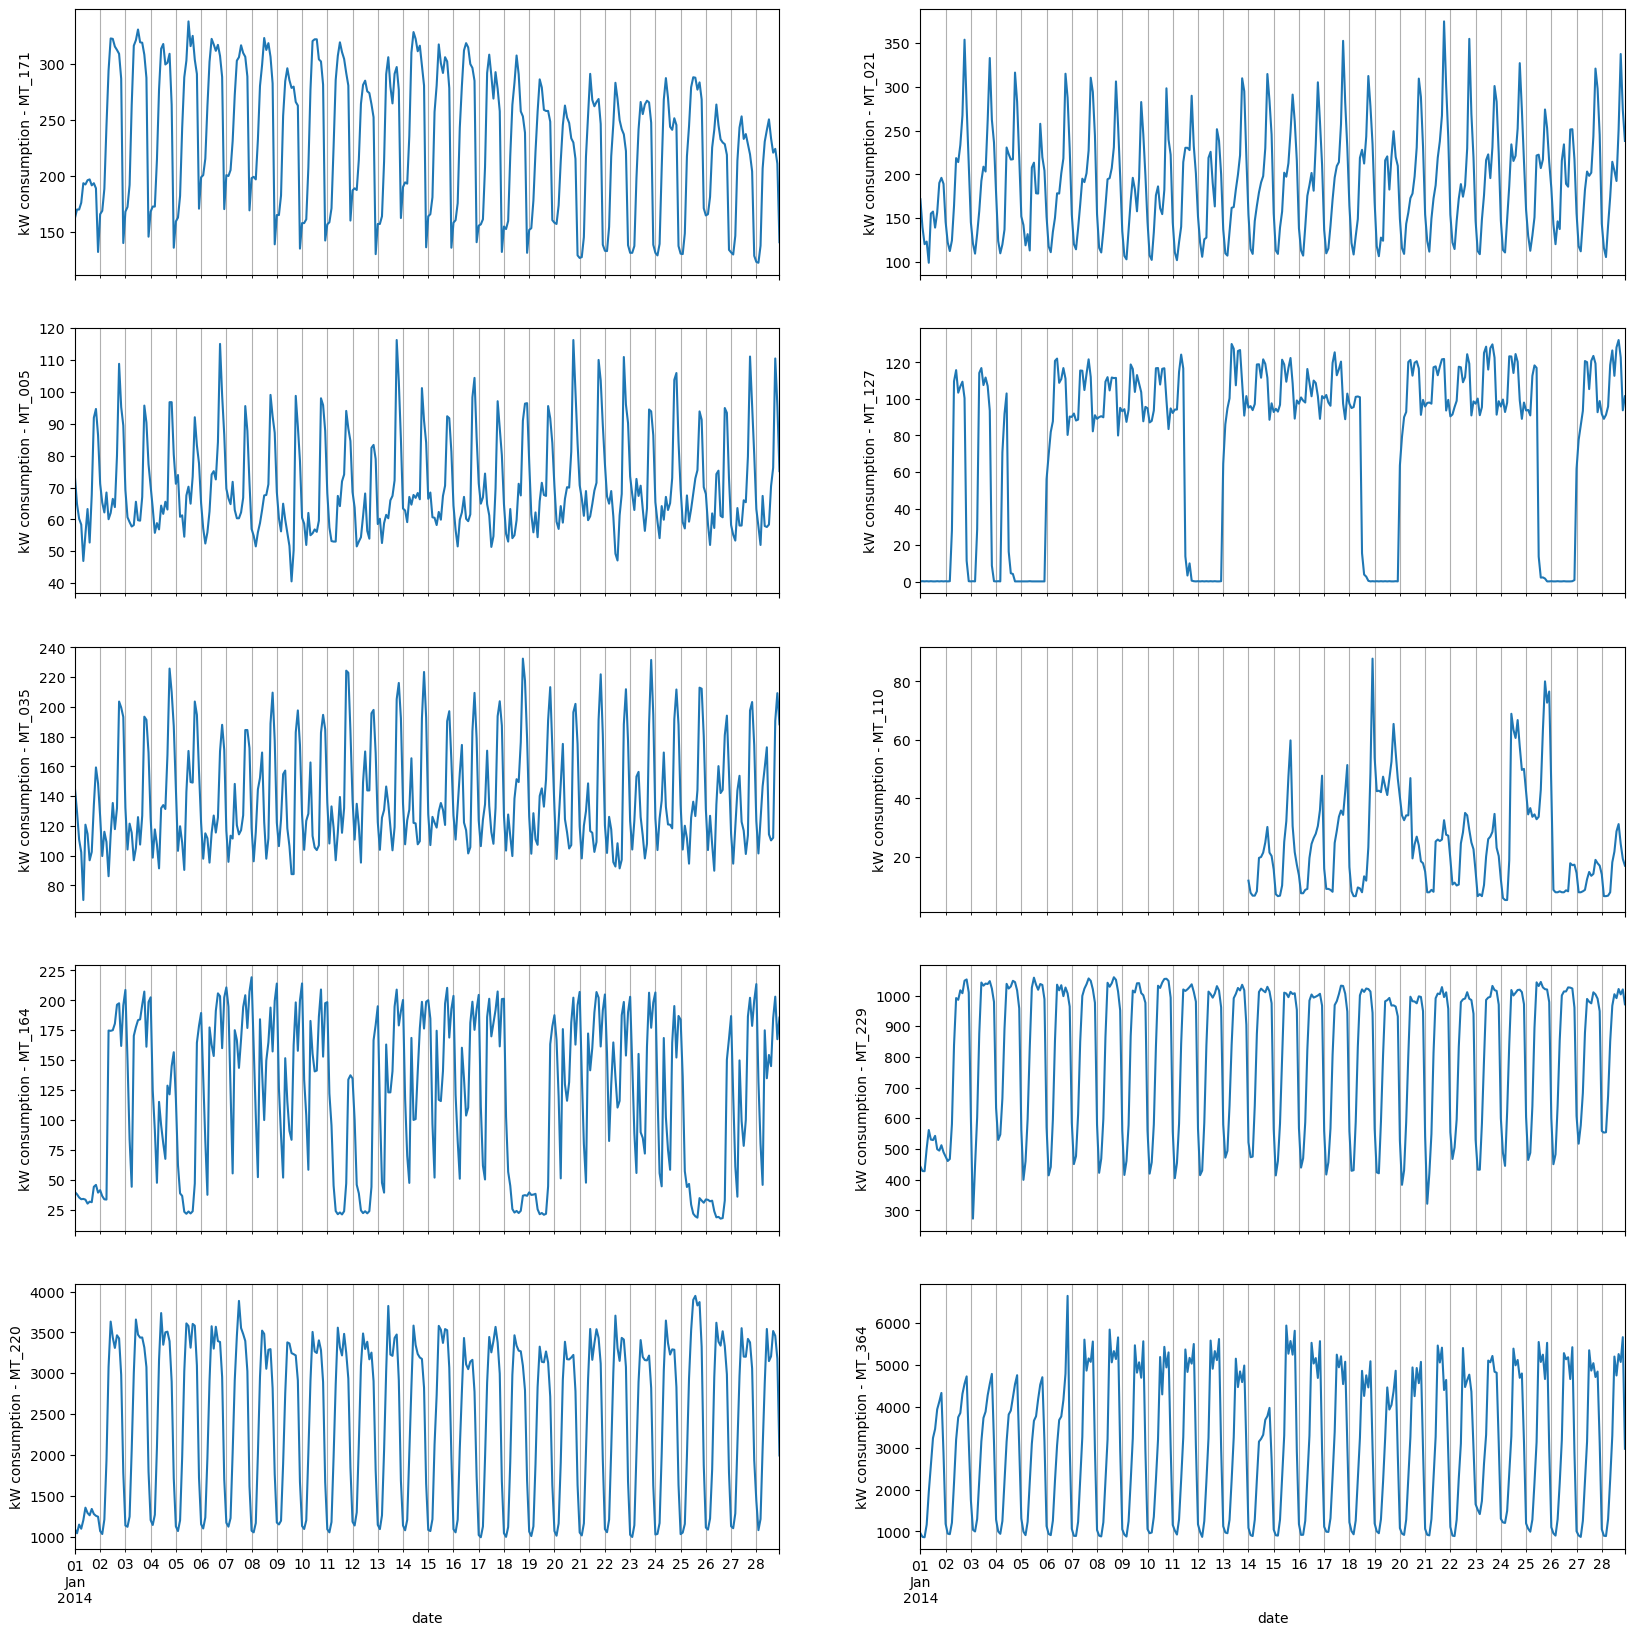

In [15]:
# show random timeseries for 28 day period
sample_size = 10
fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i, ts in enumerate(random.sample(timeseries, sample_size)):
    series = ts.loc["2014-01-01":"2014-01-28"]
    if len(series): series.plot(ax=axx[i])
    axx[i].set_xlabel("date")
    axx[i].set_ylabel(f"kW consumption - {ts.name}")
    axx[i].grid(which="minor", axis="x")

In [15]:
data_kw.iloc[:, 1]

2011-01-01 00:00:00     0.000000
2011-01-01 02:00:00     0.000000
2011-01-01 04:00:00     0.000000
2011-01-01 06:00:00     0.000000
2011-01-01 08:00:00     0.000000
                         ...    
2014-12-31 16:00:00    28.538407
2014-12-31 18:00:00    28.449502
2014-12-31 20:00:00    24.004267
2014-12-31 22:00:00    21.692745
2015-01-01 00:00:00     2.489331
Freq: 2H, Name: MT_002, Length: 17533, dtype: float64

In [16]:
data_kw.describe()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,17533.000000,17533.000000,17533.000000,17533.000000,17533.000000,17533.000000,17533.000000,17533.000000,17533.000000,17533.000000,...,17533.000000,17533.000000,17533.000000,17533.000000,17533.000000,17533.000000,17533.000000,17533.000000,17533.000000,17533.000000
mean,3.970558,20.767296,2.918141,82.179803,37.238185,141.219330,4.521080,191.390559,39.973074,42.202745,...,218.201255,37605.842554,1887.319716,2939.864049,65.409419,9.269180,424.238706,94.699316,625.216072,8721.857663
std,5.562407,13.111807,10.502964,57.225869,26.103235,96.873570,6.445249,120.586540,28.919864,32.416723,...,200.621569,37997.606073,1779.560735,2673.255168,63.796634,9.463367,270.255170,78.976286,379.726889,9162.423267
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.158629,2.756046,0.000000,49.542683,17.530488,79.613095,0.989259,119.107744,16.389860,11.424731,...,23.643826,3637.500000,334.388186,119.318182,10.267275,0.000000,17.998244,22.746244,365.469208,0.000000
50%,1.903553,25.071124,1.737619,88.922764,39.634146,158.482143,3.038440,223.905724,41.739510,42.204301,...,146.056388,24562.500000,1084.388186,2272.727273,40.417210,7.094792,522.058824,81.803005,760.813783,0.000000
75%,3.172589,30.227596,1.846221,115.599593,54.725610,203.869048,4.522329,278.198653,56.818182,62.365591,...,394.093505,53500.000000,3286.392405,5213.068182,108.213820,10.898186,624.561018,153.171953,873.625367,17867.567568
max,29.822335,55.209815,149.109470,272.611789,127.286585,465.773810,43.810062,497.895623,135.270979,180.376344,...,755.442541,189737.500000,7116.561181,9849.431818,329.204694,44.470451,961.369622,328.255426,1433.284457,26756.756757


### Convert data to Autopilot format

For Autopilot training you need to prepare the dataset in a [specific format](https://docs.aws.amazon.com/sagemaker/latest/dg/timeseries-forecasting-data-format.html).

In [17]:
# Melt the DataFrame
melted_df = pd.melt(
    data_kw.reset_index(),
    id_vars='index', 
    value_vars=data_kw.columns, 
    var_name='mt_id', 
    value_name='consumption'
)

# Rename the 'index' column to 'timestamp'
melted_df = melted_df.rename(columns={'index': 'ts'})

print(melted_df)

                         ts   mt_id   consumption
0       2011-01-01 00:00:00  MT_001      0.000000
1       2011-01-01 02:00:00  MT_001      0.000000
2       2011-01-01 04:00:00  MT_001      0.000000
3       2011-01-01 06:00:00  MT_001      0.000000
4       2011-01-01 08:00:00  MT_001      0.000000
...                     ...     ...           ...
6487205 2014-12-31 16:00:00  MT_370  12033.783784
6487206 2014-12-31 18:00:00  MT_370   9554.054054
6487207 2014-12-31 20:00:00  MT_370   8344.594595
6487208 2014-12-31 22:00:00  MT_370   7263.513514
6487209 2015-01-01 00:00:00  MT_370    891.891892

[6487210 rows x 3 columns]


In [18]:
melted_df.to_csv('./data/autopilot_ts_train.csv', index=False, header=True)

In [19]:
!aws s3 rm {s3_data_path}/train/ --recursive

delete: s3://sagemaker-us-east-1-906545278380/autopilot-demo-notebook/data/train/autopilot_ts_train.csv


In [20]:
!aws s3 cp ./data/autopilot_ts_train.csv {s3_data_path}/train/autopilot_ts_train.csv

upload: data/autopilot_ts_train.csv to s3://sagemaker-us-east-1-906545278380/autopilot-demo-notebook/data/train/autopilot_ts_train.csv


In [21]:
!aws s3 ls {s3_data_path}/train/ 

2024-09-30 08:50:11  274368348 autopilot_ts_train.csv


## Run an Autopilot job
Define training job specifications. Refer to the [Autopilot documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/autopilot-create-experiment-timeseries-forecasting.html#timeseries-forecasting-api-required-params), boto3 [create_auto_ml_job_v2](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker/client/create_auto_ml_job_v2.html), and SageMaker Python SDK [AutoMLV2](https://sagemaker.readthedocs.io/en/stable/api/training/automlv2.html#sagemaker.automl.automlv2.AutoMLV2) and [AutoMLTimeSeriesForecastingConfig](https://sagemaker.readthedocs.io/en/stable/api/training/automlv2.html#sagemaker.automl.automlv2.AutoMLTimeSeriesForecastingConfig) classes for more information about interface specification.

For the supported time series algorithms see the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/timeseries-forecasting-algorithms.html).

Note the usage of the [`CompletionCriteria`](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_AutoMLJobCompletionCriteria.html) parameter to limit the run time of an individual training job, number of candidates, or overall AutoML job run time for the cost control. This notebook sets the overall time limit to 40 minutes in the `MaxRuntimePerTrainingJobInSeconds` parameter. If you want to run the full AutoML experiment, you can remove the `CompletionCriteria`. The full AutoML job for this dataset and with all algorithms enabled takes between 90 and 120 minutes to complete.

In [38]:
# predict for 7 days
prediction_days = 7
intervals_per_day = 12
prediction_length = prediction_days * intervals_per_day
forecast_quantiles = ['p10','p50','p90']
max_automl_job_runtime = 40 * 60 # set to 40 minutes

# use the following available timeseries algorithms
automl_algorithms = [
    'cnn-qr',
    'deepar',
    'prophet',
    'npts',
    'arima',
    'ets'
]

In [41]:
# set the parameters for AutoML job

# inputs
automl_job_input_data_config = [
    {  'ChannelType': 'training',
            'ContentType': 'text/csv;header=present',
            'CompressionType': 'None',
        'DataSource': {
            'S3DataSource': {
                'S3DataType': 'S3Prefix',
                'S3Uri': f'{s3_data_path}/train/',
            }
        }
    }
]

# outputs
output_data_config = {'S3OutputPath': s3_output_path}

# available metrics for time series forecasting: RMSE, wQL, Average wQL, MASE, MAPE, WAPE
automl_job_objective = {'MetricName': 'AverageWeightedQuantileLoss'}

# problem-specific config, time series in this case
automl_problem_type_config ={
        'TimeSeriesForecastingJobConfig': {
            'CompletionCriteria': {
                'MaxAutoMLJobRuntimeInSeconds': max_automl_job_runtime
            },
            'ForecastFrequency': freq.upper(), # Autopilot needs H in the uppercase,
            'ForecastHorizon': prediction_length,
            'ForecastQuantiles': forecast_quantiles,
            'Transformations': {
            'Filling': {
                'consumption': {
                    'middlefill' : 'nan',
                    'backfill' : 'nan'
                    },                      
            }
            },
            'TimeSeriesConfig': {
                'TargetAttributeName': 'consumption',
                'TimestampAttributeName': 'ts',
                'ItemIdentifierAttributeName': 'mt_id',
            },
            'CandidateGenerationConfig': {
                'AlgorithmsConfig': [
                    {
                        'AutoMLAlgorithms': automl_algorithms
                    },
                ]
            }
        }
    }

With parameters now defined, invoke the [training job](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker/client/create_auto_ml_job_v2.html) and monitor for its completion.

<div class="alert alert-info">
If you're running this notebook parallel to the Canvas experiment, you might have an exception <code>An error occurred (ResourceLimitExceeded) when calling the CreateAutoMLJobV2 operation</code> in <code>create_auto_ml_job_v2</code> call. This is because of an account-level limit of maximum number of AutoML jobs running in parallel. You need to wait until other AutoML job completed or you can stop one of the jobs.
</div>

Note, you can enable automatic deployment of the best candidate model by specifying [`ModelDeployConfig`](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateAutoMLJobV2.html#sagemaker-CreateAutoMLJobV2-request-ModelDeployConfig) in the API call.

In [42]:
timestamp_suffix = strftime("%Y%m%d-%H%M%S", gmtime())
automl_job_name = "automl-ts-" + timestamp_suffix
print("The base AutoML job name: " + automl_job_name)

The base AutoML job name: automl-ts-20241001-091815


In [43]:
sm.create_auto_ml_job_v2(
    AutoMLJobName=automl_job_name,
    AutoMLJobInputDataConfig=automl_job_input_data_config,
    OutputDataConfig=output_data_config,
    AutoMLProblemTypeConfig = automl_problem_type_config,
    AutoMLJobObjective=automl_job_objective,
    RoleArn=sm_role,
)

{'AutoMLJobArn': 'arn:aws:sagemaker:us-east-1:906545278380:automl-job/automl-ts-20241001-091815',
 'ResponseMetadata': {'RequestId': 'fcf38b85-f56f-4c21-94d9-2636977b8c1c',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'fcf38b85-f56f-4c21-94d9-2636977b8c1c',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '96',
   'date': 'Tue, 01 Oct 2024 09:18:18 GMT'},
  'RetryAttempts': 0}}

The SageMaker Autopilot job runs asynchronously. The following cell waits until the job finishes by using the [describe_auto_ml_job_v2](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker/client/describe_auto_ml_job_v2.html) API call.

<div style="border: 4px solid coral; text-align: center; margin: auto;">
The AutoML job run time is limited to 40 minutes. Please take this time to work other labs in this workshop and come back to this notebook later on.
</div>

In [ ]:
while sm.describe_auto_ml_job_v2(AutoMLJobName=automl_job_name)["AutoMLJobStatus"] not in ("Failed", "Completed", "Stopped"):
    r = sm.describe_auto_ml_job_v2(AutoMLJobName=automl_job_name)
    job_run_status = r["AutoMLJobStatus"]

    print(
        datetime.datetime.now(),
        r["AutoMLJobStatus"] 
        + " - " 
        + r["AutoMLJobSecondaryStatus"]
    )
    sleep(180)
else:
    print(f"{automl_job_name} completed")

2024-10-01 09:18:25.910494 InProgress - PreTraining
2024-10-01 09:21:26.200807 InProgress - PreTraining
2024-10-01 09:24:26.461780 InProgress - TrainingModels
2024-10-01 09:27:26.769908 InProgress - TrainingModels
2024-10-01 09:30:27.046131 InProgress - TrainingModels
2024-10-01 09:33:27.231862 InProgress - TrainingModels
2024-10-01 09:36:27.508018 InProgress - TrainingModels
2024-10-01 09:39:27.687263 InProgress - TrainingModels
2024-10-01 09:42:27.976528 InProgress - TrainingModels
2024-10-01 09:45:28.168861 InProgress - TrainingModels
2024-10-01 09:48:28.457257 InProgress - TrainingModels
2024-10-01 09:51:28.736076 InProgress - TrainingModels
2024-10-01 09:54:28.976546 InProgress - TrainingModels
2024-10-01 09:57:29.267270 InProgress - TrainingModels
2024-10-01 10:00:29.497074 InProgress - TrainingModels
2024-10-01 10:03:29.800592 InProgress - TrainingModels
2024-10-01 10:06:30.084304 InProgress - TrainingModels
2024-10-01 10:45:33.857954 InProgress - EnsemblingModels
2024-10-01 10:

## Explore AutoML training run results

Once training is completed, you can use the [`describe_auto_ml_job_v2`](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker/client/describe_auto_ml_job_v2.html) function get details about the AutoML job run. 

If training completed, the `BestCandidate` key contains all information about the best performing model, which is an ensemble of trained candidates. The information includes the calculated metrics, container definitions, model artifact, backtest reports, and notebooks.

If the training was stopped based on the `CompletionCriteria` parameter, you can use [`list_candidates_for_auto_ml_job`](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker/client/list_candidates_for_auto_ml_job.html) function to iterate over all trained models and choose the best based on your requirements and data.

The code cells below demonstrate these approaches.

### Get the best candidate model

In [45]:
r = sm.describe_auto_ml_job_v2(AutoMLJobName=automl_job_name)
print(f"""
Job {automl_job_name} finished with the status: {r["AutoMLJobStatus"]} - {r["AutoMLJobSecondaryStatus"]}
Total duration: {(r['EndTime'] - r['CreationTime']).seconds//60} minutes
""")


Job automl-ts-20241001-091815 finished with the status: Completed - Completed
Total duration: 93 minutes



In [46]:
if r.get('BestCandidate'):
    print("Get the best candidate from the job details")
    best_candidate = r['BestCandidate']
else:
    print("Find the best candidate from the individual training jobs")
    candidates = sm.list_candidates_for_auto_ml_job(
        AutoMLJobName=automl_job_name,
        StatusEquals='Completed',
        SortOrder='Ascending',
        SortBy='FinalObjectiveMetricValue',
    )

    # print all completed candidate jobs with the objective metric value
    [print(f"{c['CandidateName']}:\t{c['FinalAutoMLJobObjectiveMetric']['Value']}") for c in candidates['Candidates']]

    best_candidate = candidates['Candidates'][0]

best_candidate

Get the best candidate from the job details


{'CandidateName': 'automl-ts-20241001-091815-trial-me-1',
 'FinalAutoMLJobObjectiveMetric': {'Type': 'Minimize',
  'MetricName': 'AVERAGE_WEIGHTED_QUANTILE_LOSS',
  'Value': 0.1261603683233261,
  'StandardMetricName': 'AverageWeightedQuantileLoss'},
 'ObjectiveStatus': 'Succeeded',
 'CandidateSteps': [{'CandidateStepType': 'AWS::SageMaker::TrainingJob',
   'CandidateStepArn': 'arn:aws:sagemaker:us-east-1:906545278380:training-job/automl-ts-20241001-091815-me-1-2448aa2ec2404572b5d1fece94e73bdf',
   'CandidateStepName': 'automl-ts-20241001-091815-me-1-2448aa2ec2404572b5d1fece94e73bdf'}],
 'CandidateStatus': 'Completed',
 'InferenceContainers': [{'Image': '473393118567.dkr.ecr.us-east-1.amazonaws.com/autopilot-timeseries:latest',
   'ModelDataUrl': 's3://sagemaker-us-east-1-906545278380/autopilot-demo-notebook/output/automl-ts-20241001-091815/automl-ts-20241001-091815-trial-TimeSeriesModelTraining/models/model-ensemble/full-dataset/automl-ts-20241001-091815-me-1-2448aa2ec2404572b5d1fece94

Use the Python SDK `Estimator` class to get a DataFrame with model metrics. Amazon SageMaker Autopilot time series produces these [metrics to evaluate the model candidates](https://docs.aws.amazon.com/sagemaker/latest/dg/timeseries-objective-metric.html).

In [47]:
best_candidate_name = best_candidate['CandidateName']
best_training_job_name = [
    s['CandidateStepName'] for s in best_candidate['CandidateSteps'] 
        if s['CandidateStepType'] in ['AWS::SageMaker::TrainingJob']
][0]
print(f"The best candidate training job name: {best_training_job_name}")

The best candidate training job name: automl-ts-20241001-091815-me-1-2448aa2ec2404572b5d1fece94e73bdf


In [48]:
estimator = sagemaker.estimator.Estimator.attach(best_training_job_name)


2024-10-01 10:51:49 Starting - Preparing the instances for training
2024-10-01 10:51:49 Downloading - Downloading the training image
2024-10-01 10:51:49 Training - Training image download completed. Training in progress.
2024-10-01 10:51:49 Uploading - Uploading generated training model
2024-10-01 10:51:49 Completed - Training job completed


In [49]:
model_metrics_df = estimator.training_job_analytics.dataframe()
model_metrics_df

,timestamp,metric_name,value
0,0.0,RMSE,510.978178
1,0.0,MAPE,1.392904
2,0.0,AverageWeightedQuantileLoss,0.126160
3,0.0,MASE,3.309544
4,0.0,WAPE,0.165660


### Save the model performance to a file

In [50]:
os.makedirs("./model-performance", exist_ok=True)

In [52]:
experiment_name = f"{experiment_prefix}-{freq}-{data_kw.shape[1]}-{data_kw.shape[0]}"

In [53]:
model_metrics_df['experiment'] = experiment_name
model_metrics_df['timestamp'] = timestamp_suffix
model_metrics_df = model_metrics_df[['timestamp','metric_name','value','experiment']]
model_metrics_df

,timestamp,metric_name,value,experiment
0,20241001-091815,RMSE,510.978178,autopilot-full-2h-370-17533
1,20241001-091815,MAPE,1.392904,autopilot-full-2h-370-17533
2,20241001-091815,AverageWeightedQuantileLoss,0.126160,autopilot-full-2h-370-17533
3,20241001-091815,MASE,3.309544,autopilot-full-2h-370-17533
4,20241001-091815,WAPE,0.165660,autopilot-full-2h-370-17533


In [54]:
model_metrics_df.to_csv(f'./model-performance/{experiment_name}-{timestamp_suffix}.csv', index=False)

### Deploy the model

Given the best candidate, you can deploy the model as a SageMaker real-time endpoints. This notebook uses the Python SDK [`AutoMLV2`](https://sagemaker.readthedocs.io/en/stable/api/training/automlv2.html#sagemaker.automl.automlv2.AutoMLV2) class to deploy the endpoint. Alternatively you can use boto3 API for the deployment as well.

Follow the documentation [Autopilot model deployment and forecasts](https://docs.aws.amazon.com/sagemaker/latest/dg/timeseries-forecasting-deploy-models.html) to understand how to format inference payload and response.

In [ ]:
# select the instance based on the quota availability
ep_instance_type = get_best_instance(ep_instance_quota_code_map)

assert ep_instance_type, "You don't have quotas for required endpoint instance"

<div class="alert alert-info">If you get an exception <code>ResourceLimitExceeded</code> when calling the <code>deploy()</code> method, you might already utilize the available quota for the specific type of ML instances. Try another instance for what you have a quota available or delete an existing endpoint if you don't need it anymore.</div>

In [59]:
# attach the existing AutoML job to an AutoMLV2 object
automl = AutoMLV2.attach(automl_job_name)

In [60]:
endpoint_name = f"{best_candidate_name}-{strftime('%Y%m%d-%H%M%S', gmtime())}"

automl.deploy(
    initial_instance_count=1,
    instance_type=ep_instance_type,
    candidate=best_candidate,
    endpoint_name=endpoint_name,
    sagemaker_session=sagemaker_session,
)

----------!

In [52]:
# this code shows how to deploy the best model using boto3 API
# best_candidate_containers = best_candidate['InferenceContainers'] 

# model_name = best_candidate_name
# endpoint_name = f"{best_candidate_name}-{strftime('%Y%m%d-%H%M%S', gmtime())}"
# endpoint_config_name = f"epc-{endpoint_name}"

# production_variants = [
#     {
#         "InstanceType": "ml.m5.4xlarge",
#         "InitialInstanceCount": 1,
#         "ModelName": model_name,
#         "VariantName": "AllTraffic",
#     }
# ]

# sm.create_model(
#     ModelName=model_name,
#     ExecutionRoleArn=sm_role,
#     Containers=best_candidate_containers
# )

# sm.create_endpoint_config(
#     EndpointConfigName=endpoint_config_name,
#     ProductionVariants=production_variants
# )

# sm.create_endpoint(
#     EndpointName=endpoint_name, 
#     EndpointConfigName=endpoint_config_name,
# )

# Wait until the endpoint has the status InService
# waiter = sagemaker_session.sagemaker_client.get_waiter('endpoint_in_service')
# waiter.wait(EndpointName=endpoint_name)

### Real-time inference
Use the deployed model for real-time inferencer requests.

Forecasting models predict for the forecast horizon time steps in the future as specified as a hyperparameter at the training. In this case the forecast generated from the `target end date` to the `target end date + forecast length`.

To use the model for predicting specific dates, you should provide the data in the same format as the original input data, extended up to a specified target end date. The model starts predicting from the `end_training` timestamp and generates predictions for 7 days * 14 interval per days = 84 time steps.

Refer to the Developer Guide's [Autopilot model deployment and forecasts](https://docs.aws.amazon.com/sagemaker/latest/dg/timeseries-forecasting-deploy-models.html#timeseries-forecasting-realtime) for more details.

In [61]:
sm_rt = boto3.client('sagemaker-runtime')

In [62]:
# prepare an inference dataset for test
start_dataset = pd.Timestamp("2014-12-01 00:00:00", unit=freq)
end_training = pd.Timestamp("2015-01-01 00:00:00", unit=freq)

# take the first time series for the inference
inference_ts = timeseries[0][start_dataset:end_training].to_frame()

inference_df = pd.melt(
    inference_ts.reset_index(),
    id_vars='index', 
    value_vars=inference_ts.columns, 
    var_name='mt_id', 
    value_name='consumption'
)

inference_df = inference_df.rename(columns={'index': 'ts'})
inference_df

,ts,mt_id,consumption
0,2014-12-01 00:00:00,MT_001,2.220812
1,2014-12-01 02:00:00,MT_001,2.379442
2,2014-12-01 04:00:00,MT_001,2.220812
3,2014-12-01 06:00:00,MT_001,2.062183
4,2014-12-01 08:00:00,MT_001,1.110406
...,...,...,...
368,2014-12-31 16:00:00,MT_001,2.379442
369,2014-12-31 18:00:00,MT_001,2.220812
370,2014-12-31 20:00:00,MT_001,2.379442
371,2014-12-31 22:00:00,MT_001,2.062183


In [63]:
def predict(
    sagemaker_runtime_client,
    endpoint_name,
    payload_df
) -> pd.DataFrame :
    r = sagemaker_runtime_client.invoke_endpoint(
        EndpointName=endpoint_name,
        Body=payload_df.to_csv(index=False),
        ContentType='text/csv',
)

    return pd.read_csv(StringIO(r['Body'].read().decode()), header=0)    

The model always returns the predictions for the forecast horizon (prediction length) that was set at the training time:

In [64]:
%%time
predict(sm_rt, endpoint_name, inference_df)

CPU times: user 15.4 ms, sys: 3.93 ms, total: 19.4 ms
Wall time: 26.9 s


,mt_id,ts,p10,p50,p90,mean
0,MT_001,2015-01-01 02:00:00,1.379228,1.993573,2.588915,1.982410
1,MT_001,2015-01-01 04:00:00,1.478147,2.124273,2.716005,2.109727
2,MT_001,2015-01-01 06:00:00,1.178652,1.889596,2.471615,1.872687
3,MT_001,2015-01-01 08:00:00,1.024901,1.737659,2.495081,1.748516
4,MT_001,2015-01-01 10:00:00,0.492074,1.429164,2.227740,1.422800
...,...,...,...,...,...,...
79,MT_001,2015-01-07 16:00:00,1.123635,2.185969,3.155205,2.157396
80,MT_001,2015-01-07 18:00:00,0.966835,2.022630,2.990124,1.998431
81,MT_001,2015-01-07 20:00:00,0.868862,1.862677,2.842727,1.857028
82,MT_001,2015-01-07 22:00:00,0.658658,1.681598,2.596875,1.658062


Define a plotting function that sends an input DataFrame to the endpoint and then plots the prediction result.

In [65]:
def plot(
    input_ts,
    forecast_date=end_training,
    plot_history=prediction_length,
    display_data=False,
):
    freq = input_ts.index.freq
    print(f"calling the endpoint to generate predictions starting from {str(forecast_date)}")

    # construct the dataframe to send to the model
    inference_ts = input_ts[
        forecast_date - plot_history*freq : forecast_date
    ].to_frame()

    inference_df = pd.melt(
        inference_ts.reset_index(),
        id_vars='index', 
        value_vars=inference_ts.columns, 
        var_name='mt_id', 
        value_name='consumption'
    ).rename(columns={'index': 'ts'})

    if display_data:
        print(f"""
        Input data:
        {inference_df}
        """)

    # call the end point to get the prediction
    prediction_df = predict(sm_rt, endpoint_name, inference_df)
    
    prediction_df['ts'] = pd.to_datetime(prediction_df['ts'])
    prediction_df = prediction_df.set_index('ts')

    if display_data:
        print(f"""
        Model output:
        {prediction_df}
        """)

    fig = plt.figure(figsize=(20, 6))
    ax = plt.subplot(1, 1, 1)
    ax.set_title(f"{input_ts.name}")

    # plot the input series
    input_section = input_ts[
        forecast_date - plot_history * freq : forecast_date + prediction_length * freq
    ]
    input_section.plot(color="black", label="target")

    # plot the confidence interval p90-p10, p50, and the median predicted
    ax.fill_between(
        prediction_df['p10'].index,
        prediction_df['p10'].values,
        prediction_df['p90'].values,
        color="b",
        alpha=0.3,
        label="{}% confidence interval".format(80),
    )
    prediction_df['mean'].plot(color="r", label="mean")
    prediction_df['p50'].plot(color="b", label="P50")
    ax.legend(loc='upper left')

    # fix the scale as the samples may change it
    ax.set_ylim(input_section.min() * 0.5, input_section.max() * 1.5)

    plt.tight_layout()
    plt.show()

Play with different time series, history lengths, and forecast start date to generate predictions for `prediction_length` number of periods. You can change the following parameters:
- `Time series id:`: id of the time series
- `Offset`: if set to 0, the forecast starts from the end of the training period. You can enter a negative number which specifies how many days **before** the end of the training period the forecast should starts. This allows you to see the actual values - shown as **target** on the plot - together with the predictions
- `History length`: how `prediction lengths` of history are shown on the plot
- `Show datasets`: turn on this option if you would like to see the input and output datasets

In [66]:
style = {"description_width": "initial"}
ts_id_list = [ts.name for ts in timeseries]

In [67]:
@interact_manual(
    ts_ids=Select(options=ts_id_list, value=ts_id_list[0], rows=5, description='Time series id:'),
    offset=IntSlider(min=-100, max=0, value=0, style=style, description='Offset:'),
    history_length=IntSlider(min=2, max=20, value=2, style=style, description='History length:'),
    display_data = Checkbox(value=False, style=style, description='Display datasets'),
    continuous_update=False,
)
def plot_interact(ts_ids, offset, history_length, display_data):
    plot(
        input_ts=[ts for ts in timeseries if ts.name in ts_ids][0],
        forecast_date=end_training + datetime.timedelta(days=offset),
        plot_history=history_length * prediction_length,
        display_data=display_data,
    )

interactive(children=(Select(description='Time series id:', options=('MT_001', 'MT_002', 'MT_003', 'MT_004', '…

### Batch inference
You can also run offline inference using the same model with [SageMaker Batch Transform](https://docs.aws.amazon.com/sagemaker/latest/dg/timeseries-forecasting-deploy-models.html#timeseries-forecasting-batch). This a preferrable option for large datasets because real-time inference has the maximum request payload size 6 MB and 60-second timeout.

To run a batch inference job you need to create a model and start a job with the [`create_transform_job`](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker/client/create_transform_job.html) boto3 call.

Refer to a hands-on example of the batch inference in this [notebook](https://github.com/aws/amazon-sagemaker-examples/blob/main/autopilot/autopilot_time_series.ipynb).

## Autopilot time series forecasting limits
Be aware about hard and soft limits for the Autopilot time series forecast:
[Amazon SageMaker Autopilot time-series forecasting resource limits](https://docs.aws.amazon.com/sagemaker/latest/dg/timeseries-forecasting-limits.html).

---

## Clean up

In [68]:
sm.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '57cc5b01-b845-49b1-a242-ca0ec2afa35c',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '57cc5b01-b845-49b1-a242-ca0ec2afa35c',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 01 Oct 2024 13:32:53 GMT',
   'content-length': '0'},
  'RetryAttempts': 0}}

## Shutdown kernel

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>